# Análisis Galeria Inmobiliaria - Vivienda Nueva Bogotá - Primer Semestre 2023

## Cargue de librerías

En esta sección se realiza el cargue de las librerías necesarias para el procesamiento de los datos

In [454]:
import pandas as pd
import requests
import json
import time
import swifter
import geopandas as gpd
from shapely.geometry import Point
import shapely.wkt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import unicodedata
import numpy as np

import contextily as cx
import chart_studio.plotly as py
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

## Configuración y parametrización

En esta sección se definen los parámetros básicos de visualización de los dataframes y se definen las variables para establecer las bases de interés (datos de inmuebles nuevos e isocronas EMB).

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path_vivienda_nueva = 'data/JULIO/Bogota_Def_07-23.xlsb'
path_isocronas = 'data/Isocronas/Isocrona por estacion TOTAL 2022.shp'

In [1121]:
sheet_name_pro = 'Base Proyectos'
sheet_name_inm = 'Base Formulada'
var_fecha = 'Día'
var_tipo = 'Tipo'
var_vis_no_vis = 'Tipo de Vivienda ( Vis o No Vis )'
var_activo = 'Activo'
var_zona = 'Zona'
#Zonas internas de Bogotá
arr_zonas = ['Norte', 'Suba', 'Chicó', 'Multicentro', 'Salitre', 'Modelia', 'Occidente', 'Centro', 'Sur Oriente']

var_venta_total = 'V. Total Proyecto'
val_2022_reference_date = '2022-05-01'
val_2023_reference_date = '2023-05-01'
var_emb_fecha = 'EMBFechaInicio'

arr_campos_pro = ['Codproyecto','Entrega (Obra Gris o Acabados)','Tipo de Vivienda ( Vis o No Vis )','Of. Total Proyecto','Tiempo','layer','Linea','geometry']
arr_campos_inm = ['Codproyecto','Codinmueble','Estrato','Tipo','Area','Rango $','Rango m2','Rango $m2']
id_field_list = arr_campos_inm+arr_campos_pro
id_field_list = list(dict.fromkeys(id_field_list))

arr_rango_precio = ['0 - VIP','VIP - VIS','VIS - 200','200 - 400','400 - 700','700 - 900','Mayor 900']
arr_rango_m2 = ['0 - 50', '50 - 75', '75 - 100', '100 - 125', '125 - 150', '150 - 200',' > 200']
arr_rango_precio_m2 = ['0 - 2000', '2000 - 3000', '3000 - 4000','4000 - 5000','5000 - 6000', '6000 - 7000', 'Mayor 7000']
arr_rango_estrato = [2, 3, 4, 5, 6]
arr_rango_tipo = ['Apto.', 'Casa', 'Lote']
arr_rango_tiempo = ['5 min', '10 min','15 min', '20 min']
arr_rango_estaciones_l1 = ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15','E16']
arr_rango_estaciones_l2 = ['1','2','3','4','5','6','7','8','9','10','11']
arr_rango_estaciones = arr_rango_estaciones_l1 + arr_rango_estaciones_l2
arr_rango_lineas = ['Linea 1','Linea 2']


## Cargue de insumos

En esta sección se realiza el cargue de los diferentes insumos para su posterior procesamiento. Adicionalmente, se parametrizan las funciones de cargue a partir de la estructura y definición de cada una de las fuentes.

In [277]:
df_vivienda_nueva = pd.read_excel(path_vivienda_nueva, sheet_name=sheet_name_pro)

In [278]:
df_vivienda_nueva = gpd.GeoDataFrame(data=df_vivienda_nueva, geometry=gpd.points_from_xy(df_vivienda_nueva['Longitud\n(Coordenada Real)'], df_vivienda_nueva['Latitud (Coordenada Real)']), crs="EPSG:4326")                                                                                                          

In [ ]:
df_inmuebles = pd.read_excel(path_vivienda_nueva, sheet_name=sheet_name_inm)

In [279]:
df_isocronas = gpd.read_file(path_isocronas)

## Funciones

Función para calcular la fecha a partir de la representación numérica generada por Excel

In [280]:
def excel_num_to_date(excel_date_num):
    return pd.Timestamp('1900-01-01') + pd.to_timedelta(excel_date_num - 2, unit='D')

Función para generar lista de meses a consultar

In [923]:
def generate_month_list(start_year, start_month, end_year, end_month):
    months = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
    month_list = []

    year = start_year
    month = months.index(start_month)

    while year < end_year or (year == end_year and month <= months.index(end_month)):
        month_list.append(f"{months[month]}{str(year)[2:]}")
        month += 1
        if month == 12:
            month = 0
            year += 1

    return month_list


Función para generar lista de años

In [984]:
def generate_year_list(start_year, end_year):
    year_list = [str(year) for year in range(start_year, end_year + 1)]
    return year_list

## Procesamiento

Se calcula la fecha a partir del dato convertido por Excel. 

In [635]:
df_vivienda_nueva[var_emb_fecha] = df_vivienda_nueva.apply(lambda x: excel_num_to_date(x[var_fecha]), axis=1)

Se realiza un filtro espacial de la zona de interés para la EMB a partir de las isocronas de línea 1 y línea 2

In [843]:
df_vivienda_zona = gpd.sjoin(df_vivienda_nueva, df_isocronas)[arr_campos_pro]

In [1142]:
df_vivienda_zona = df_vivienda_zona.rename(columns={'layer':'Estacion'})
id_field_list = list(map(lambda x: x.replace('layer', 'Estacion'), id_field_list))

Se carga la información de inmuebles y se filtra con base en los proyectos de área de estudio

In [1191]:
arr_meses = generate_month_list(2016, 'ene', 2023, 'jun')
arr_unidades_meses = ['V'+i for i in arr_meses]
arr_precios_meses = ['P'+i for i in arr_meses]
arr_valor_venta_meses = ['T'+i for i in arr_meses]
arr_area_meses = ['A'+i for i in arr_meses]
arr_anios = generate_year_list(2016,2023)

In [1192]:
df_inmuebles_zona = pd.merge(left=df_inmuebles[arr_campos_inm+arr_unidades_meses+arr_precios_meses], right=df_vivienda_zona, on='Codproyecto')

## Exploración

In [640]:
df_viz = df_vivienda_zona.copy().to_crs(epsg=3857)

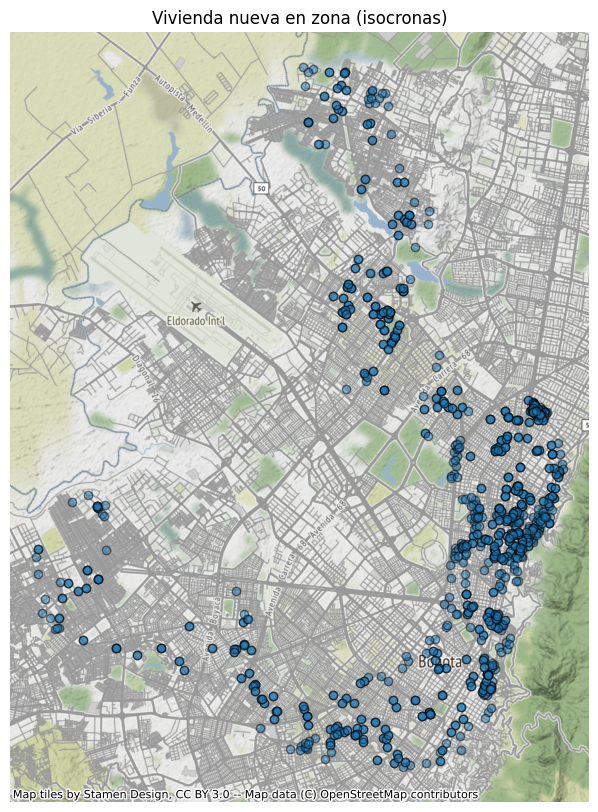

In [641]:
ax = df_viz['geometry'].plot(figsize=(15, 10), alpha=0.5, edgecolor="k")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Vivienda nueva en zona (isocronas)")
cx.add_basemap(ax)

In [1193]:
df_inmuebles_zona_def = df_inmuebles_zona[id_field_list+arr_unidades_meses+arr_precios_meses]

In [1194]:
for i in range(0,len(arr_valor_venta_meses)):
    col = arr_valor_venta_meses[i]
    df_inmuebles_zona_def[col] = df_inmuebles_zona_def[arr_unidades_meses[i]]*df_inmuebles_zona_def[arr_precios_meses[i]]
    col = arr_area_meses[i]
    df_inmuebles_zona_def[col] = df_inmuebles_zona_def[arr_unidades_meses[i]]*df_inmuebles_zona_def['Area']

/var/folders/yx/tcv_gbf53jl3v39crm08ky3m0000gn/T/ipykernel_19445/3770197483.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/yx/tcv_gbf53jl3v39crm08ky3m0000gn/T/ipykernel_19445/3770197483.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/yx/tcv_gbf53jl3v39crm08ky3m0000gn/T/ipykernel_19445/3770197483.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [1195]:
df_inmuebles_zona_def = df_inmuebles_zona_def.fillna(0)

In [1196]:
df_inmuebles_zona_def_unpivot = pd.melt(df_inmuebles_zona_def, id_vars = id_field_list, value_vars = arr_precios_meses+arr_unidades_meses+arr_valor_venta_meses+arr_area_meses, var_name='Medida', value_name='Valor').fillna(0)


In [1197]:
df_inmuebles_zona_def_unpivot['Año'] = df_inmuebles_zona_def_unpivot['Medida'].str[-2:]

In [1198]:
df_inmuebles_zona_def_unpivot['Periodo'] = df_inmuebles_zona_def_unpivot['Medida'].str[-5:]

In [1199]:
df_inmuebles_zona_def_unpivot['Medida'] = df_inmuebles_zona_def_unpivot['Medida'].str[0]

In [1200]:
df_inmuebles_zona_def_unpivot_gb = df_inmuebles_zona_def_unpivot.groupby(by=['Estrato','Tipo','Area','Rango $','Rango m2','Rango $m2','Entrega (Obra Gris o Acabados)','Tipo de Vivienda ( Vis o No Vis )','Of. Total Proyecto','Tiempo','Estacion','Linea','Medida','Periodo','Año']).agg(Valor=('Valor','sum'))


In [1201]:
df_inmuebles_zona_def_unpivot_gb = df_inmuebles_zona_def_unpivot_gb.reset_index()


In [1214]:
#columns_to_plot = ['Medida','Estrato']
#columns_to_plot = ['Medida','Tipo']
#columns_to_plot = ['Medida','Rango $']
#columns_to_plot = ['Medida','Rango m2']
#columns_to_plot = ['Medida','Rango $m2']
#columns_to_plot = ['Medida','Tiempo']
columns_to_plot = ['Medida','Estacion']
#columns_to_plot = ['Medida','Linea']
#cols_order = arr_rango_estrato
#cols_order = arr_rango_tipo
#cols_order = arr_rango_precio
#cols_order = arr_rango_m2
#cols_order = arr_rango_precio_m2
#cols_order = arr_rango_tiempo
cols_order = arr_rango_estaciones_l1
#cols_order = arr_rango_lineas
#index_col = 'Periodo'
index_col = 'Año'

In [1233]:
df_filter = df_inmuebles_zona_def_unpivot_gb['Linea']=='Linea 1'
#df_filter = df_inmuebles_zona_def_unpivot_gb['Periodo'].str[:3].isin(['ene', 'feb', 'mar', 'abr', 'may', 'jun'])
#df_filter = (df_inmuebles_zona_def_unpivot_gb['Periodo'].str[:3].isin(['ene', 'feb', 'mar', 'abr', 'may', 'jun']))&(df_inmuebles_zona_def_unpivot_gb['Linea']=='Linea 1')

In [1234]:
df = df_inmuebles_zona_def_unpivot_gb[df_filter].pivot_table(index=index_col, columns=columns_to_plot,
                          values='Valor',
                          aggfunc='sum')

In [1235]:
if 'P' in df.columns:
    del df['P']
df = df.rename(columns={'A': 'Área', 'T': 'Ventas', 'V': 'Unidades'})

In [1236]:
#df_sorted = df.reindex(arr_meses)
df_sorted = df.copy()

In [1237]:
df_sorted

Medida     Área                                                              \
Estacion     E1       E10       E11       E12       E13       E14       E15   
Año                                                                           
16        594.0   5023.26   2569.17   9272.02  51832.23  37712.34  43354.43   
17          0.0  10902.65   6694.52  27150.44  44705.16  37836.84  32138.04   
18          0.0  25402.68   1804.59  49564.67  78220.94  46414.40  38585.73   
19          0.0  17857.45   6274.75  72334.85  88735.76  37001.02  40912.13   
20          0.0  16990.31   4527.00  43714.81  52575.49  17212.61  17099.15   
21          0.0  26800.96   1681.33  35321.00  66256.47  10480.02  20823.74   
22          0.0  55596.29  48966.58  65391.56  33060.58  12952.73  18232.46   
23          0.0   7768.07   7799.14  11460.96   9038.65   5988.24   7445.23   

Medida                                                                      \
Estacion       E16       E2       E3      E4        E5        E6        E7   
Año                                                                          
16        19542.69  3581.68 -20815.0  9120.0   9308.00    188.00      0.00   
17        14917.45  1243.32   1150.0  6156.0   6156.00   2510.90   3037.90   
18        14211.26   110.00  10580.0  7068.0   8395.50   4268.40   4368.50   
19        15120.61  7895.00  16563.0  6612.0  10152.00   5439.94   3448.65   
20        11336.47     0.00    138.0  2470.0   5025.64   3641.05   2107.63   
21        49111.91     0.00      0.0  3572.0   8559.89  15422.24  10625.35   
22        28635.35     0.00      0.0   418.0   3995.81   8717.03  33466.33   
23        15175.27     0.00      0.0    76.0   1871.64   1386.12   -516.14   

Medida                              Ventas                              \
Estacion        E8        E9            E1           E10           E11   
Año                                                                      
16            0.00   8592.80  1.014800e+09  1.770635e+10  9.015466e+09   
17        10226.17  13635.42  0.000000e+00  4.345203e+10  2.523416e+10   
18         4045.97  29581.92  0.000000e+00  9.912761e+10  7.052864e+09   
19         1998.31  13610.55  0.000000e+00  8.060953e+10  2.759903e+10   
20         1403.22  12906.49  0.000000e+00  7.531766e+10  1.959940e+10   
21         1240.00  29538.34  0.000000e+00  1.183655e+11  7.425800e+09   
22        28550.26  17273.69  0.000000e+00  2.847274e+11  2.808364e+11   
23           25.13   3991.27  0.000000e+00  3.994630e+10  4.928360e+10   

Medida                                                            \
Estacion           E12           E13           E14           E15   
Año                                                                
16        4.741122e+10  3.063514e+11  2.326847e+11  2.633545e+11   
17        1.527851e+11  2.731444e+11  2.482155e+11  2.079492e+11   
18        2.539225e+11  4.697299e+11  3.279822e+11  2.498643e+11   
19        3.768182e+11  5.396204e+11  2.823187e+11  2.798904e+11   
20        2.262070e+11  3.360276e+11  1.380221e+11  1.319461e+11   
21        1.837267e+11  3.757180e+11  8.629518e+10  1.576424e+11   
22        3.825157e+11  2.363798e+11  1.138105e+11  1.461632e+11   
23        8.058110e+10  7.548145e+10  5.142309e+10  6.079857e+10   

Medida                                                            \
Estacion           E16            E2            E3            E4   
Año                                                                
16        1.650797e+11  7.303742e+09 -3.856676e+10  2.544000e+10   
17        1.289355e+11  2.589387e+09  2.797533e+09  1.856000e+10   
18        1.171076e+11  2.600000e+08  2.636415e+10  2.176200e+10   
19        1.210358e+11  2.191000e+10  4.472381e+10  2.400500e+10   
20        1.028122e+11  0.000000e+00  3.720000e+08  9.583550e+09   
21        4.131313e+11  0.000000e+00  0.000000e+00  1.390730e+10   
22        2.426689e+11  0.000000e+00  0.000000e+00  1.583850e+09   
23        1.544103e+11  0.0

In [1238]:
cumulative_values = df_sorted.cumsum()

In [1239]:
cumulative_values = cumulative_values.groupby(level = 0, axis = 1).sum()

In [1240]:
draw_acum = False

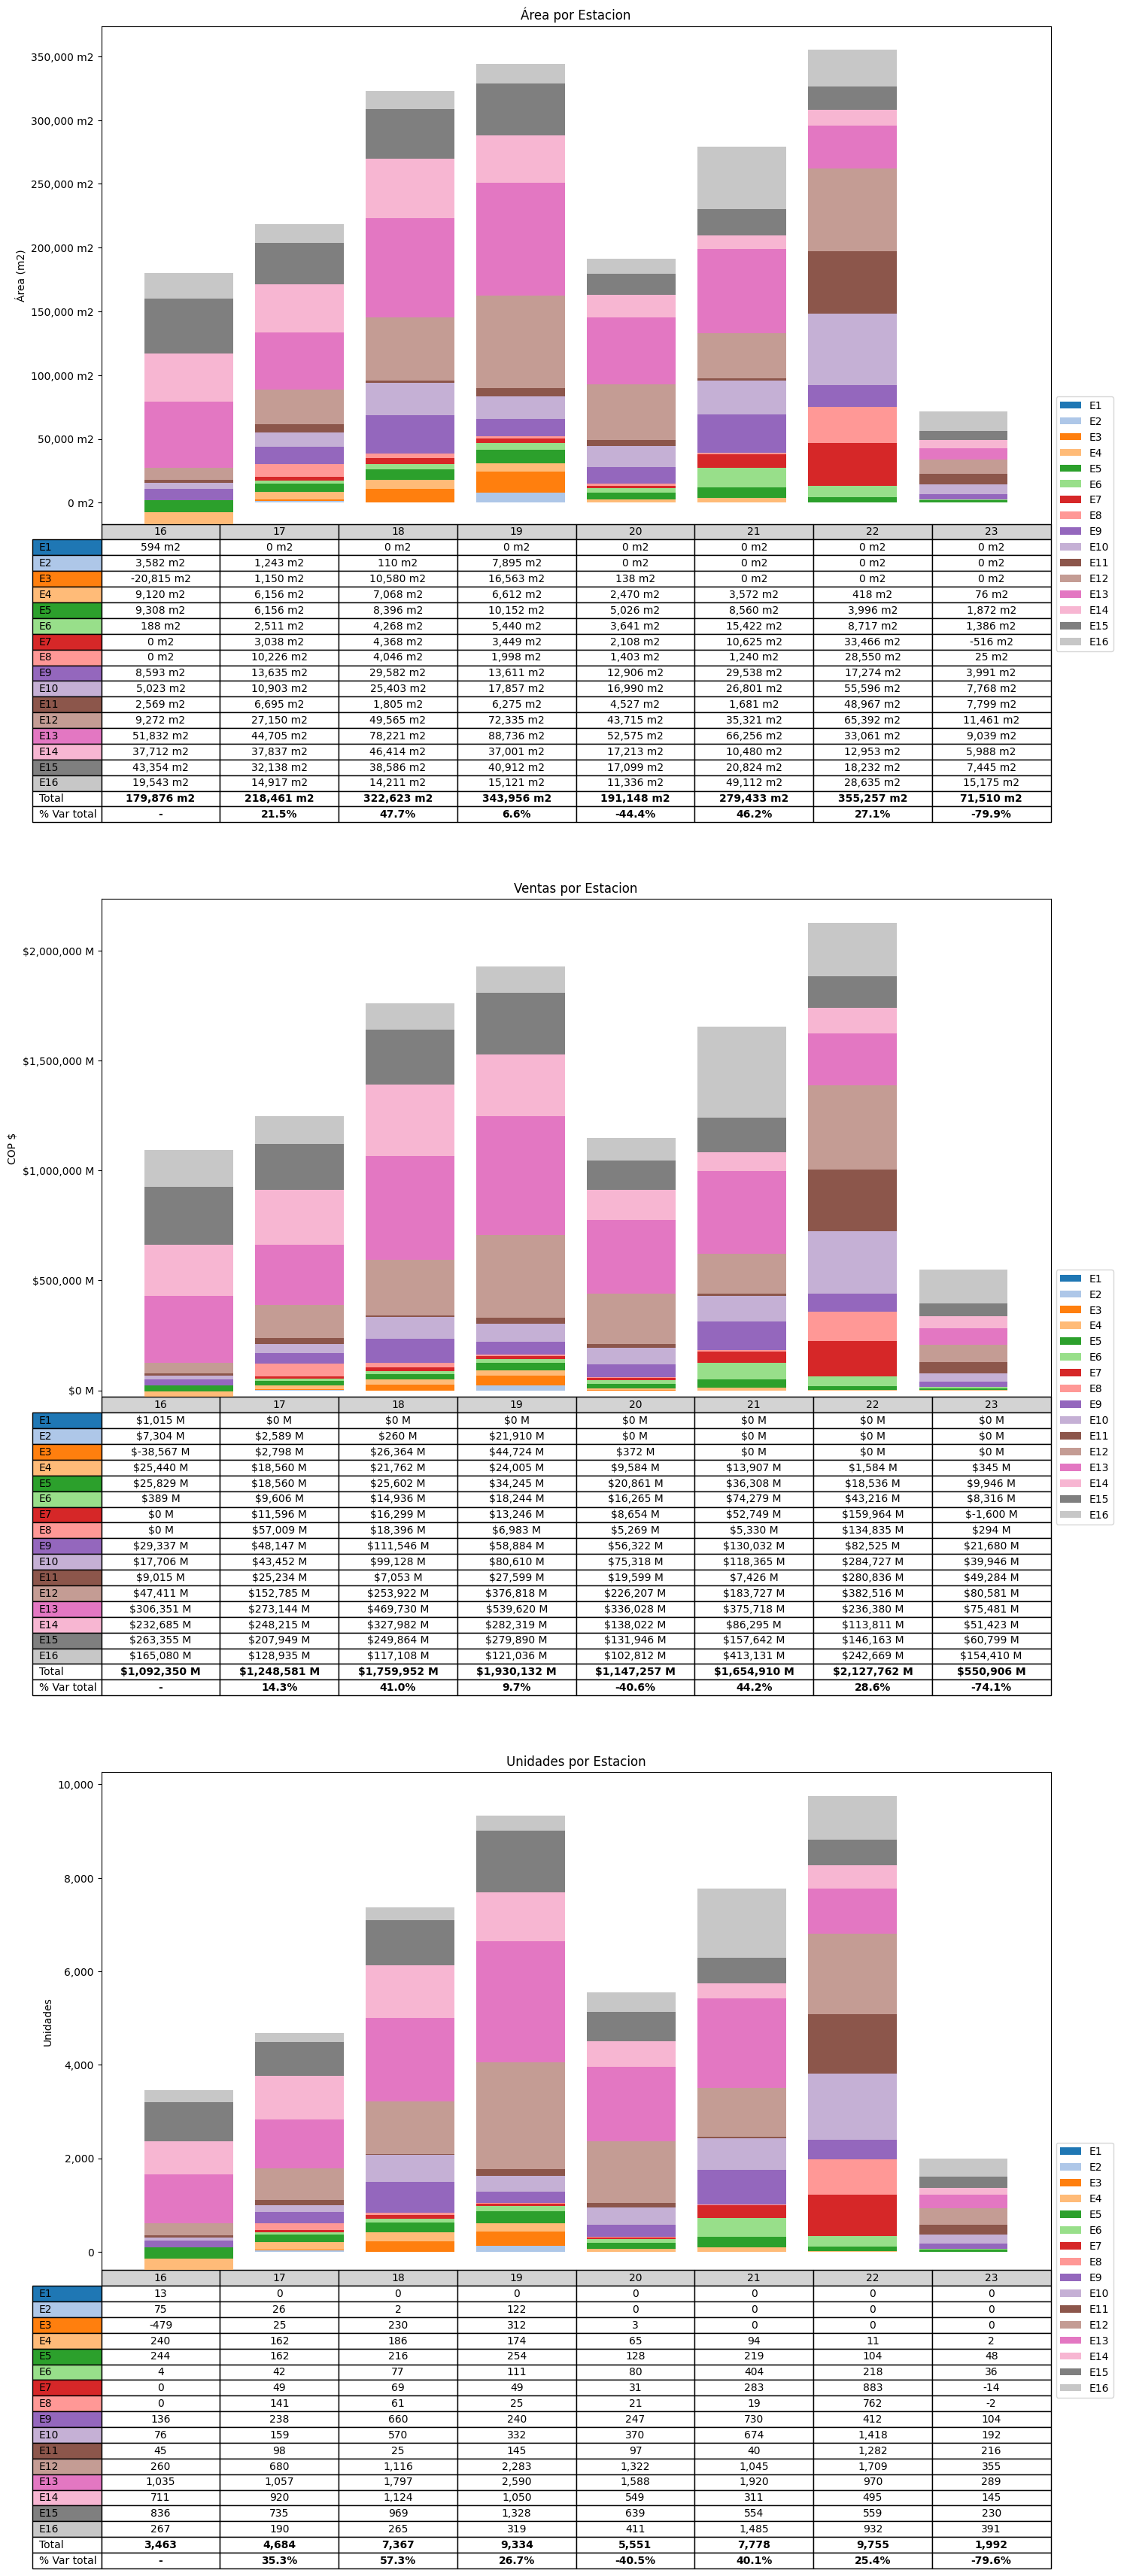

In [1249]:
level_0_values = df_sorted.columns.get_level_values(0).unique()
fig, ax = plt.subplots(len(level_0_values), 1, figsize=(15, 35))

for i, measure in enumerate(level_0_values):
    sub_df = df_sorted[measure]
    colors = plt.cm.tab20(range(len(cols_order)))
    def_colors = []
    bar_width = 1/len(sub_df.index)
    ax[i].set_xticks(range(len(sub_df.index)))
    ax[i].set_xticklabels(sub_df.index)
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    x = np.arange(len(sub_df.index)) + 0.5
    bottoms = np.zeros(len(sub_df.index))
    
    table_data = []
    for j, column in enumerate(cols_order):
        def_colors.append(colors[j])
        ax[i].bar(x, sub_df[column], label=column, color=colors[j],bottom=bottoms)
        bottoms += sub_df[column] # Update the 'bottoms' for the next bar
        if i == 0:
            table_data.append(sub_df[column].apply('{:,.0f} m2'.format).tolist())
        elif i == 1:
            table_data.append((sub_df[column]/1000000).apply('${:,.0f} M'.format).tolist())
        else:
            table_data.append(sub_df[column].apply('{:,.0f}'.format).tolist())

     
    # Calculate the total for each column and add it to the table data
    totals = sub_df[sub_df.columns].sum(axis=1)
    total_row = []
    for total in totals:
        if i == 0:
            total_row.append('{:,.0f} m2'.format(total))
        elif i == 1:
            total_row.append('${:,.0f} M'.format(total/1000000))
        else:
            total_row.append('{:,.0f}'.format(total))
    table_data.append(total_row)
    
    variation_row = []
    for j in range(1, len(totals)):
        variation = (totals[j] - totals[j-1]) / totals[j-1] * 100
        variation_row.append('{:.1f}%'.format(variation))
    table_data.append(['-'] + variation_row)

    
    table = ax[i].table(cellText=table_data, colColours=['lightgray']*len(sub_df.index), colLabels=sub_df.index, cellLoc='center', loc='bottom', rowColours=def_colors+['white']*2, rowLabels=cols_order+['Total','% Var total'])
    table.scale(1, 1.5)
    
    total_row_index = len(table_data) - 1
    variation_row_index = len(table_data)
    for j in range(len(sub_df.index)):
        table[total_row_index, j].set_text_props(fontweight='bold')
        table[variation_row_index, j].set_text_props(fontweight='bold')

    
    ax[i].set_xticks([])
     
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0 + 0.1, box.width * 0.8, box.height * 0.9])  # Adjust subplot position

    if draw_acum:
        ax[i].plot(cumulative_values.index, cumulative_values[measure], marker='.', label='Acumulado', color='lightgray', linestyle='dashed')

        for k, (xi, yi) in enumerate(zip(x, cumulative_values[measure])):
            if i == 0:
                ax[i].text(xi, yi, '{:,.0f} m2'.format(yi), ha="center", va="bottom", fontsize=8)
            elif i == 1:
                ax[i].text(xi, yi, '${:,.0f} M'.format(yi/1000000), ha="center", va="bottom", fontsize=8)
            else:
                ax[i].text(xi, yi, '{:,.0f}'.format(yi), ha="center", va="bottom", fontsize=8)
        
    if i == 0:
        ax[i].set_ylabel('Área (m2)')
        ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f} m2'.format(x)))
    elif i == 1:
        ax[1].set_ylabel('COP $')
        ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0f} M'.format(x/1000000)))
    else:
        ax[2].set_ylabel('Unidades')
        ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
        
    
    
    
    ax[i].set_title(f'{measure} por {columns_to_plot[1]}')

    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0))
    
# Adjust figure layout to prevent overlap
fig.subplots_adjust(hspace=0.25)
plt.tight_layout()
plt.show()